# Cybersecurity Intrusion Detection Pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from typing import Callable, List, Tuple, Any, Dict
import matplotlib.cm as cm
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

Please visit the website: https://www.unb.ca/cic/datasets/ids-2017.html and look around to see the problem
space and the evaluation datasets to be used for ML model development.

This dataset is collected by cyber experts during experimentation that was carried on for 5
days long. The description of the experiments also inform the experimental ground truth.
(Suggested: GeneratedLabelledFlows.zip, note that it is already pre-processed by someone)

## Helper Functions

<a id="stratified_k_fold"></a>
### stratified_k_fold

*The stratified_k_fold function runs stratified k_fold validation using the provided model function or pipeline. Stratified k-fold validation is valuable when the dependent variable is unbalanced. The function outputs the average accuracy and F1 score (with standard deviation) for the training and test sets.*

* **data** np.array: a dataset 
* **labels** List[str]: a list of feature names for the dataframe columns and rows
* **n_folds** int: the number of folds
* **num_iter** int: number of iterations
* **pipeline** Callable: a callable model or pipeline

**returns** None

In [2]:
def stratified_k_fold(data: np.array, labels: List[str], num_iter: int, n_folds: int, pipeline: Callable) -> None:
    train_f1s, train_accs, test_f1s, test_accs = [], [], [], []
    for i in range(num_iter):
        k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=i)
        for train_idx, test_idx in k_fold.split(data, labels):
            train_data, train_labels = data[train_idx], labels[train_idx]
            test_data, test_labels = data[test_idx], labels[test_idx]
            
            # train model
            pipeline.fit(train_data, train_labels)
            
            # make predictions
            train_predictions = pipeline.predict(train_data)
            test_predictions = pipeline.predict(test_data)
            
            # get evaluation metrics
            train_acc = round(100 * accuracy_score(train_labels, train_predictions), 2)
            test_acc = round(100 * accuracy_score(test_labels, test_predictions), 2)
            train_f1 = round(100 * f1_score(train_labels, train_predictions), 2)
            test_f1 = round(100 * f1_score(test_labels, test_predictions), 2)
            
            # append accuracies and f1 scores to results
            train_f1s.append(train_f1)
            test_f1s.append(test_f1)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

    print(f'Stratified 10-fold CV Train Accuracy: {np.mean(train_accs):.3f} {chr(177)}{np.std(train_accs):.4f}, Train F1 Score: {np.mean(train_f1s):.3f} {chr(177)}{np.std(train_f1s):.4f} with {num_iter} iterations')
    print(f'Stratified 10-fold CV Test Accuracy: {np.mean(test_accs):.3f} {chr(177)}{np.std(test_accs):.4f}, Test F1 Score: {np.mean(test_f1s):.3f} {chr(177)}{np.std(test_f1s):.4f} with {num_iter} iterations')

The labeled cybersecurity data contains 8 datasets demonstrating different cyber attacks. The datasets correspond to the days of the test week and specific attacks. The following section describes the datasets.

- **Monday:** Normal Activity
- **Tuesday:** Normal Activity + Brute Force Attacks
- **Wednesday:** Normal Activity + DoS/DDoS Attacks
- **Thursday (2 datasets):**
    - Normal Activity + Web Attacks
    - Normal Activity + Infiltration Attacks
- **Friday (3 datasets):**
    - Normal Activity + BotNet Attacks
    - Normal Activity + Portscan Attacks
    - Normal Activity + DDoS Attacks

In [3]:
# load the data files

# Monday -Normal Activity
mon_dataset = pd.read_csv('../EP_datasets/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv')

# Tuesday -Brute Force Attacks + Normal Activity
tues_dataset = pd.read_csv('../EP_datasets/TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv')

# Wednesday -DoS/DDoS + Normal Activity
wed_dataset = pd.read_csv('../EP_datasets/TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv')

# Thursday 1 -Morning Web Attacks + Normal Activity
thurs_dataset_1 = pd.read_csv('../EP_datasets/TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='ISO-8859-1', low_memory=False)

# Thursday 2 -Afternoon Infiltration Attacks + Normal Activity
thurs_dataset_2 = pd.read_csv('../EP_datasets/TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')

# Friday 1 -Morning BotNet Attacks + Normal Activity 
fri_dataset_1 = pd.read_csv('../EP_datasets/TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv')

# Friday 2 -Afternoon portscan + Normal Activity
fri_dataset_2 = pd.read_csv('../EP_datasets/TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')

# Friday 3 -Afternoon DDoS + Normal Activity
fri_dataset_3 = pd.read_csv('../EP_datasets/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

## Feature Exploration - Dataset 1

In [4]:
dataset_1 = wed_dataset
dataset_1.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.14-209.48.71.168-49459-80-6,192.168.10.14,49459,209.48.71.168,80,6,5/7/2017 8:42,38308,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.17-389-49453-6,192.168.10.17,49453,192.168.10.3,389,6,5/7/2017 8:42,479,11,5,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.17-88-46124-6,192.168.10.17,46124,192.168.10.3,88,6,5/7/2017 8:42,1095,10,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.17-389-49454-6,192.168.10.17,49454,192.168.10.3,389,6,5/7/2017 8:42,15206,17,12,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.17-88-46126-6,192.168.10.17,46126,192.168.10.3,88,6,5/7/2017 8:42,1092,9,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [5]:
print(f"The shape of the dataframe is:\n{dataset_1.shape}")

The shape of the dataframe is:
(692703, 85)


In [6]:
print(f"Dataset 1 contains the following features:\n{list(dataset_1.columns)}")

Dataset 1 contains the following features:
['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' 

In [7]:
# clean up leading and trailing whitespace in features
dataset_1.columns = dataset_1.columns.str.strip()
print(f"Cleaned feature names:\n{list(dataset_1.columns)}")

Cleaned feature names:
['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 

Since researchers ran the attacks at specific time intervals, the machine learning model could use the timestamp feature to detect a cyber attack even though this feature might not provide much value to the prediction. The flow ID duplicates the source and destination IP addresses with an ID. The following cell removes these features from the data frame.

In [8]:
dataset_1.drop(['Timestamp', 'Flow ID'], axis=1, inplace=True)

In [9]:
# examine feature types
types_df = pd.DataFrame(dataset_1.dtypes, columns=['DataType'])
unique_types = list(types_df['DataType'].unique())
print(f"dataset_1 consists of the following feature types:\n{[dtype.name for dtype in unique_types]}")

dataset_1 consists of the following feature types:
['object', 'int64', 'float64']


In [10]:
# convert all ints to float64
dataset_1 = dataset_1.apply(lambda col: col.astype(np.float64) if col.dtype == 'int64' else col)
types_df = pd.DataFrame(dataset_1.dtypes, columns=['DataType'])
unique_types = list(types_df['DataType'].unique())
print(f"dataset_1 consists of the following feature types:\n{[dtype.name for dtype in unique_types]}")

dataset_1 consists of the following feature types:
['object', 'float64']


In [11]:
types_df.loc[types_df['DataType'] == 'object']

,DataType
Source IP,object
Destination IP,object
Label,object


The source and destination IP addresses would require feature engineering to extract value from these variables. Encoding the IP addresses as numerical values could lose significant hierarchical information. Extracting the geolocation from the source IP or the network node from the Destination IP could provide more value for the intrusion detection pipeline. However, this analysis will drop these values rather than perform feature engineering due to time constraints. Another important note is that the data was produced in a test setting. Therefore, the source and destination IP addresses could introduce noise into the model that does not represent a real-world setting. Additionally, the destination IP addresses could cause the model to overfit to this network and not generalize well to all scenarios. The subsequent cell drops these values.

In [12]:
dataset_1.drop(['Source IP', 'Destination IP'], axis=1, inplace=True)

In [13]:
# examine missing values
null_df = pd.DataFrame(dataset_1.isnull().sum(), columns=['MissingValues'])
null_df.loc[null_df['MissingValues'] > 0]

,MissingValues
Flow Bytes/s,1008


In [14]:
inf_df = pd.DataFrame(dataset_1.isin([np.inf, -np.inf]).sum(), columns=['InfValues'])
inf_df.loc[inf_df['InfValues'] > 0]

,InfValues
Flow Bytes/s,289
Flow Packets/s,1297


There is only one feature with missing values. K nearest neighbors will work well to impute the missing values because this value should reflect other similar examples in the dataset. The positive and negative infinity values for flow bytes/s and flow packets/s will be imputed with the minimum and maximum values for the datatype because the machine learning models cannot work with infinite values.

In [15]:
# fill +inf and -inf values with min and max values for the datatype
max_float32 = np.finfo(np.float32).max
min_float32 = np.finfo(np.float32).min
dataset_1.replace([np.inf, -np.inf], [max_float32, min_float32], inplace=True)

# use KNN to impute missing flow bytes/s values
imputer = KNNImputer(n_neighbors=3)
knn_df = dataset_1.drop('Label', axis=1)
knn_df_imputed = imputer.fit_transform(knn_df)
knn_df = pd.DataFrame(knn_df_imputed, columns=knn_df.columns)
# add back to the original data
dataset_1['Flow Bytes/s'] = knn_df['Flow Bytes/s']

In [16]:
# determine labels
unique_entries = dataset_1['Label'].unique()
print(f"Dataset 1 contains the following class labels:\n{unique_entries}")

Dataset 1 contains the following class labels:
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']


The dataset contains 6 class labels. One label maps to normal network activity, and the other 5 labels map to different DoS/DDos attacks. The machine learning model will predict normal activity or a cyber attack. Subsequent sections will group all attack labels into one label to indicate a cyber attack.

## Machine Learning Methodology

A supervised learning approach will work well for `dataset_1` because this is a classification problem with a labeled dataset and many training examples. Feature exploration with respect to the dependent variable will help reduce the dimensionality of the dataset. This analysis will test a Naive Bayes classifier as the baseline model due to its simplicity and robustness. Next, a decision tree and a random forest will be compared to the baseline model. These models were selected for their ability to handle large datasets efficiently. Furthermore, random forests often perform well on cybersecurity problems. K-fold validation will be used to evaluate the models. Stratified k-fold validation will apply when the class labels are skewed. The k-fold validation functions will display the accuracy and F1 scores. The F1 score will be favored if the class distribution is skewed.

### Transform Class Labels

In [17]:
# convert all BENIGN labels to 0 and the rest to 1
dataset_1['Label'] = np.where(dataset_1['Label'] == 'BENIGN', 0, 1)

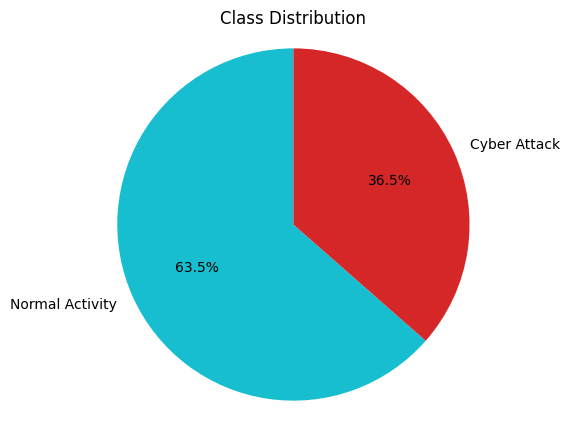

In [18]:
# plot the class distribution
fig = plt.figure(figsize=(5, 5))
labels = 'Normal Activity', 'Cyber Attack'
hd_dist = [len(dataset_1[dataset_1['Label'] == 0]), len(dataset_1[dataset_1['Label'] == 1])] 

plt.pie(hd_dist, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#17becf', '#d62728'])
plt.axis('equal')  
plt.title('Class Distribution')
plt.show()

The class distribution is slighlty skued. Therefore, the F1 score will be a good evaluation metric with stratified k-fold validation.

## Feature Exploration and Transformation

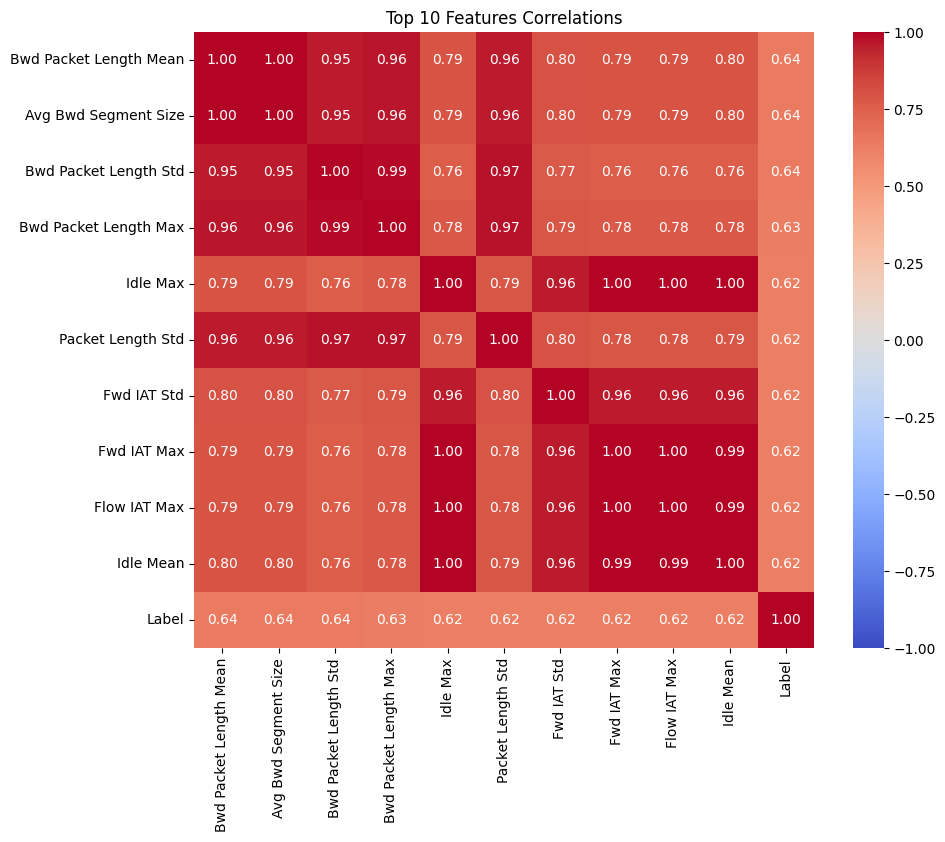

In [19]:
# get correlation matrix
correlation_matrix = dataset_1.corr()

# get the list of features, excluding 'Label'
features = [col for col in dataset_1.columns if col != 'Label']

# sort the correlations in descending order
sorted_correlations = correlation_matrix['Label'].abs().sort_values(ascending=False)

# select the top 10 most strongly correlated features
top_features = sorted_correlations[1:11].index.tolist()

# add label back to the list to include it in the heatmap
top_features.append('Label')

# display top 20 features as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 10 Features Correlations')
plt.show()

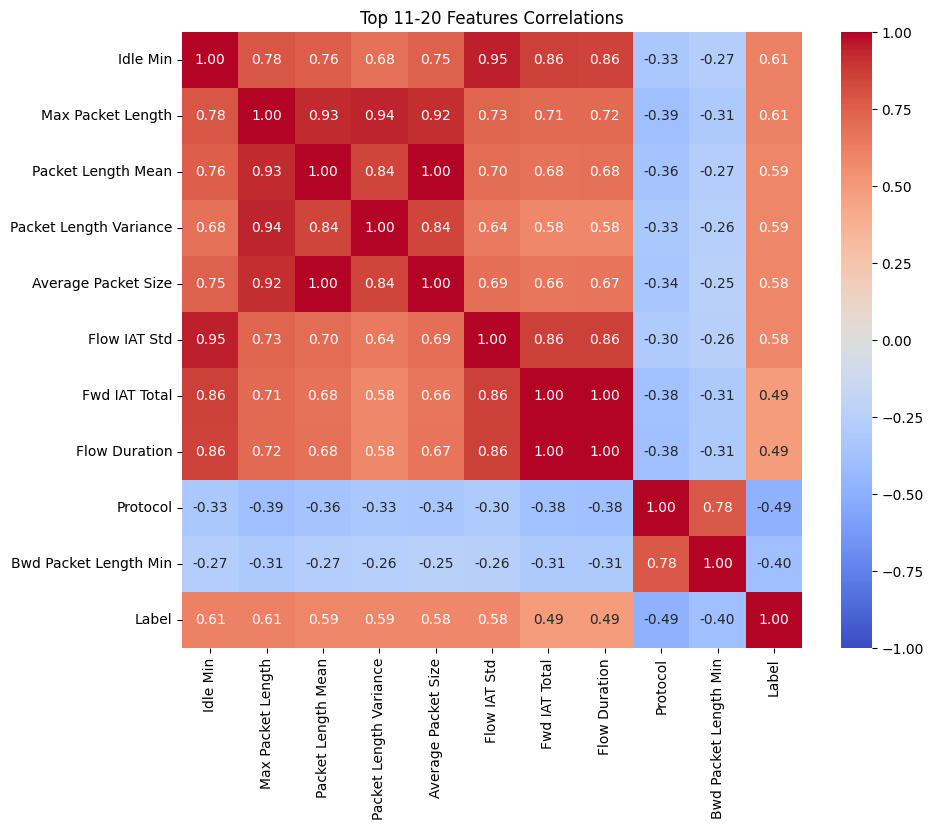

In [20]:
# select the top 11-20 most strongly correlated features
top_20_features = sorted_correlations[11:21].index.tolist()

# add label back to the list to include it in the heatmap
top_20_features.append('Label')

# display top 11-20 features as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_20_features, top_20_features], annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 11-20 Features Correlations')
plt.show()

In [21]:
# extract the correlations with the target variable 'Label'
target_correlations = correlation_matrix['Label'].drop('Label')

# filter out correlations that are below the threshold of 0.25
high_correlations = target_correlations[abs(target_correlations) > 0.25]

# create a new DataFrame for visualization below
high_corr_features_df = pd.DataFrame(high_correlations)
high_corr_features_df.reset_index(inplace=True)
high_corr_features_df.columns = ['Feature', 'CorrelationWithLabel']

The following ports are significant to the problem of detecting cyber attacks:
- 21: ftp
- 22: ssh
- 23: telnet
- 25: smtp
- 53: dns
- 80: http
- 443: https
- 8080: http-proxy
- 8443: https-proxy
- 143: imap
- 110: pop3
- 3306: MYSQL
- 445: smb
- 1433: SQL Server
- 3389: Remote Desktop Protocol

References
1. Borges, E. Top 20 and 200 most scanned ports in the cybersecurity industry. SecurityTrails blog. https://securitytrails.com/blog/top-scanned-ports#content-top-20-most-scanned-ports
2. Cyber Dan. Most Commonly Attacked Ports. //Cyber.Engineer. https://www.cyber.engineer/most-commonly-attacked-ports/

In [22]:
# one hot encode important destination ports
ports_to_flag = [
    21, 22, 23, 25, 53, 80, 443, 143, 110, 8080, 8443, 3306, 445, 1433, 3389
]

# loop through each port and create a new column
for port in ports_to_flag:
    col_name = f'destination_port_{port}'
    dataset_1[col_name] = (dataset_1['Destination Port'] == port).astype(int)
    
dataset_1['destination_port_other'] = [1 if val not in ports_to_flag else 0 for val in dataset_1['Destination Port']]
dataset_1.drop('Destination Port', axis=1, inplace=True)
print(f"New feature names:\n{list(dataset_1.columns)}")

New feature names:
['Source Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Fl

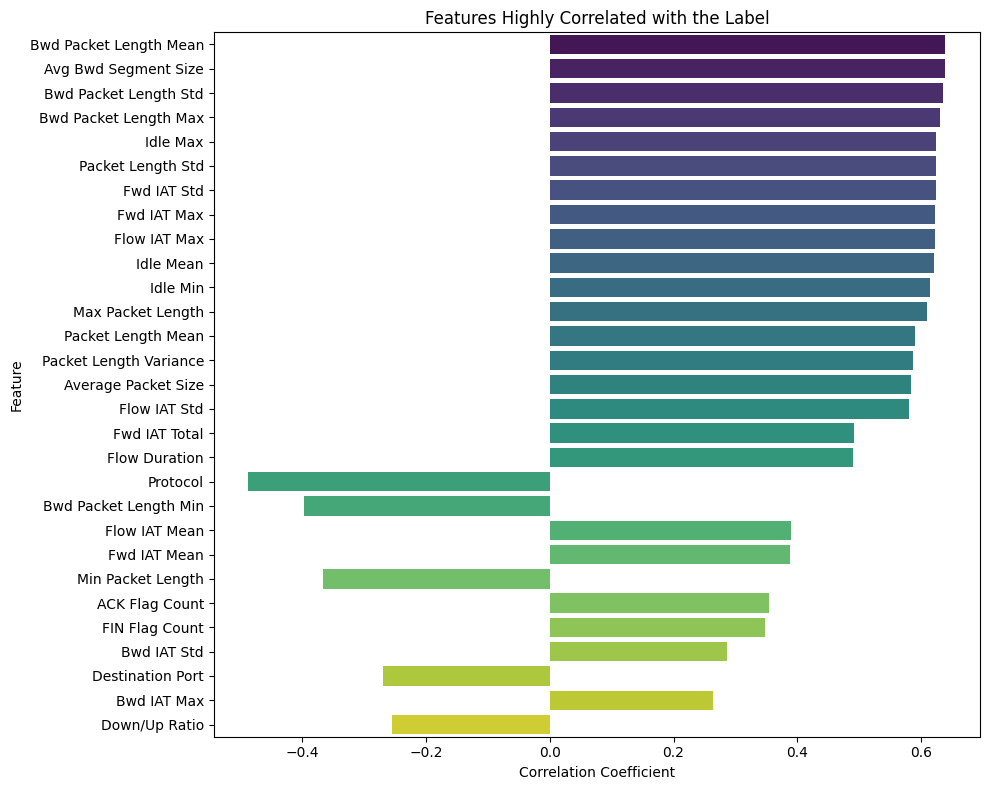

In [23]:
# visualize the top correlations above
high_corr_features_df_sorted = high_corr_features_df.sort_values('CorrelationWithLabel', key=abs, ascending=False)

# create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=high_corr_features_df_sorted, x='CorrelationWithLabel', y='Feature', palette='viridis')

plt.title('Features Highly Correlated with the Label')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

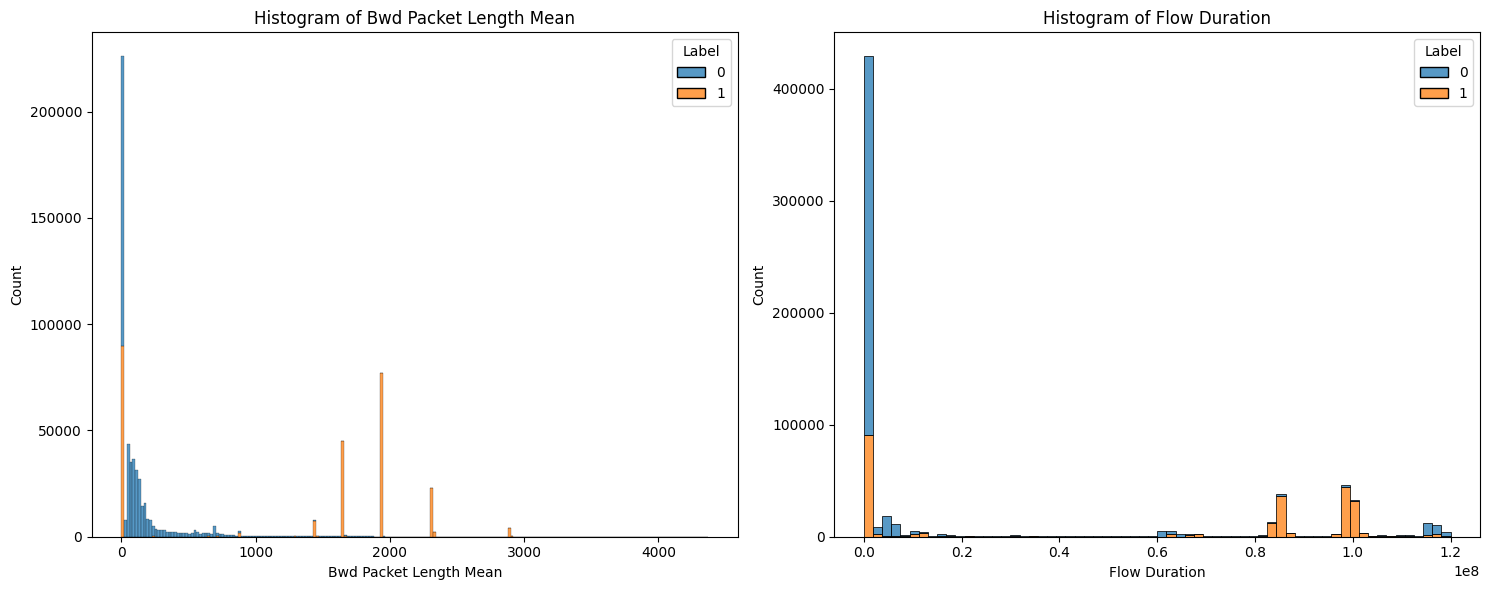

In [24]:
features_to_plot = ['Bwd Packet Length Mean', 'Flow Duration']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figsize as needed

# Plot the histogram of Bwd PAcket Length Mean
sns.histplot(data=dataset_1, x=features_to_plot[0], hue='Label', multiple="stack", ax=axes[0])
axes[0].set_title(f'Histogram of {features_to_plot[0]}')
axes[0].set_xlabel(features_to_plot[0])
axes[0].set_ylabel('Count')

# Plot the histogram of Flow Duration
sns.histplot(data=dataset_1, x=features_to_plot[1], hue='Label', multiple="stack", ax=axes[1])
axes[1].set_title(f'Histogram of {features_to_plot[1]}')
axes[1].set_xlabel(features_to_plot[1])
axes[1].set_ylabel('Count')

# Display the plot
plt.tight_layout()
plt.show()

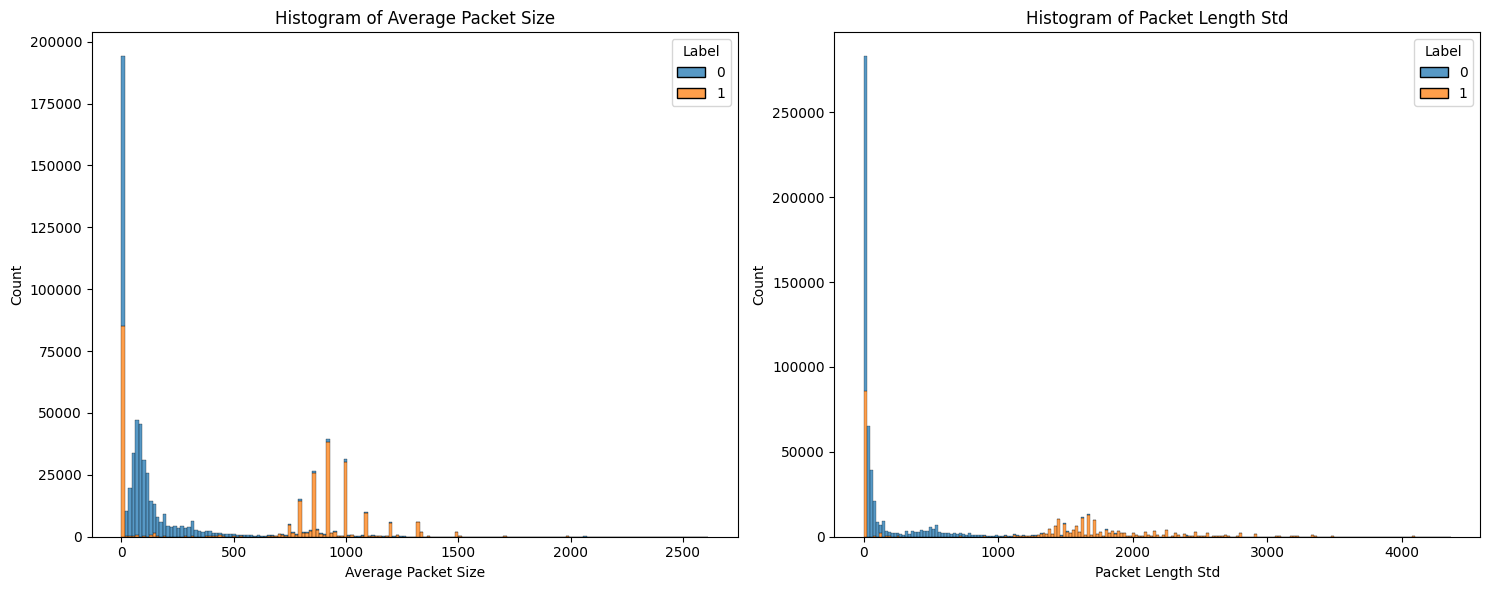

In [25]:
features_to_plot = ['Average Packet Size', 'Packet Length Std']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figsize as needed

# Plot the histogram of Bwd PAcket Length Mean
sns.histplot(data=dataset_1, x=features_to_plot[0], hue='Label', multiple="stack", ax=axes[0])
axes[0].set_title(f'Histogram of {features_to_plot[0]}')
axes[0].set_xlabel(features_to_plot[0])
axes[0].set_ylabel('Count')

# Plot the histogram of Flow Duration
sns.histplot(data=dataset_1, x=features_to_plot[1], hue='Label', multiple="stack", ax=axes[1])
axes[1].set_title(f'Histogram of {features_to_plot[1]}')
axes[1].set_xlabel(features_to_plot[1])
axes[1].set_ylabel('Count')

# Display the plot
plt.tight_layout()
plt.show()

The histograms above show that the packet and duration features provide good class separation. 

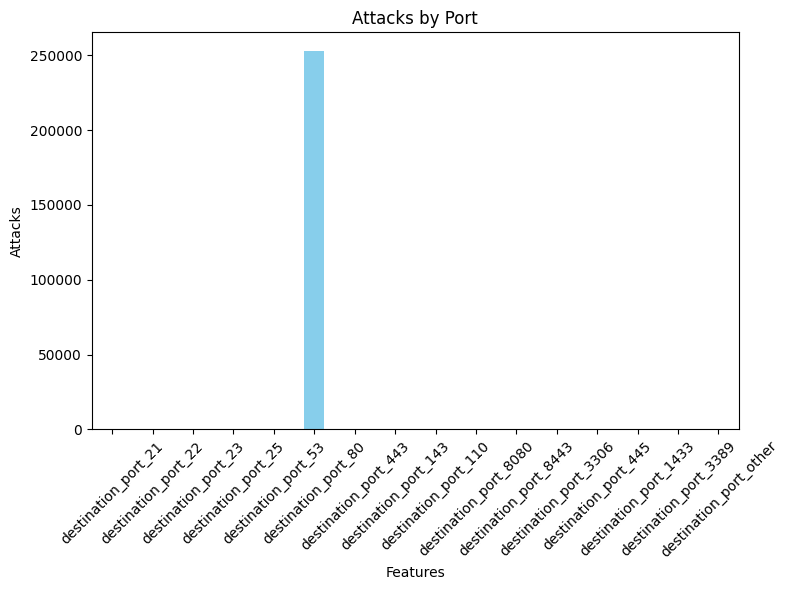

In [26]:
features = list(dataset_1.filter(regex='(port)').columns)

attack_counts = {}
# get the attack counts for all one hot encoded ports
for feature in features:
    attack_counts[feature] = dataset_1[dataset_1['Label'] == 1][feature].sum()

counts_series = pd.Series(attack_counts)

# create the bar plot
plt.figure(figsize=(8, 6))
counts_series.plot(kind='bar', color='skyblue')
plt.title('Attacks by Port')
plt.xlabel('Features')
plt.ylabel('Attacks')
plt.xticks(range(len(counts_series)), counts_series.index, rotation=45)
plt.tight_layout()
plt.show()

The plot above shows that the Wednesday dataset for DoS and DDoS attacks all had a destination port of 53. Port 53 is the DNS port. The pipeline will use all one hot encoded ports above because different attacks could have different destination ports. 

In [27]:
# use the features from the top correlation df above
top_features = list(high_corr_features_df['Feature'])
top_features.remove('Destination Port')

# add one hot encoded ports and source port to selected columns
selected_columns = list(dataset_1.filter(regex='(port|Port)').columns)

# turn into a set to avoid duplicate columns
final_features = list(set(top_features + selected_columns))

final_df_1 = dataset_1[final_features]
final_df_1.shape

(692703, 45)

## Model Evaluation

In [28]:
# dataset labels
dataset_1_labels = np.array(dataset_1['Label'])
final_data = np.array(final_df_1)

In [29]:
%%time
# Run stratified 10-fold validation using standardization and a naive bayes classifier
nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GaussianNB())
])
print("Naive Bayes Classifier:")
stratified_k_fold(final_data, dataset_1_labels, 10, 10, nb_pipeline)

Naive Bayes Classifier:
Stratified 10-fold CV Train Accuracy: 92.913 ±0.0103, Train F1 Score: 91.134 ±0.0119 with 10 iterations
Stratified 10-fold CV Test Accuracy: 92.913 ±0.0911, Test F1 Score: 91.135 ±0.1033 with 10 iterations
CPU times: user 1min, sys: 25.3 s, total: 1min 25s
Wall time: 1min 25s


In [30]:
# Run stratified 10-fold validation using standardization and a decision tree model
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=42, max_depth=5))])

print("Decision Tree Classifier:")
stratified_k_fold(final_data, dataset_1_labels, 10, 10, dt_pipeline)

Decision Tree Classifier:
Stratified 10-fold CV Train Accuracy: 99.297 ±0.0047, Train F1 Score: 99.032 ±0.0063 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.291 ±0.0322, Test F1 Score: 99.024 ±0.0454 with 10 iterations


In [31]:
# Run stratified 10-fold validation using standardization and a random forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=60, max_depth=5, max_features=10, random_state=42, n_jobs=4))
])
print("Random Forest Model:")
stratified_k_fold(final_data, dataset_1_labels, 10, 10, rf_pipeline)

Random Forest Model:
Stratified 10-fold CV Train Accuracy: 99.097 ±0.0175, Train F1 Score: 98.753 ±0.0249 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.094 ±0.0410, Test F1 Score: 98.749 ±0.0570 with 10 iterations


The decision tree classifier and the random forest had comparable performance. The decision tree had a slightly higher F1 score and lower standard deviation than the random forest. However, this model might not generalize well to other attacks and new data. The feature analysis showed that most attacks in this dataset happened on the dns port. Therefore, the decision tree model might have used this information to overfit to this dataset. Therefore, the random forest model will be used for subsequent analyses with the remaining datasets.

## Apply Data Processing and Model Fitting to Datasets 2-8

Note: this analysis could benefit from an in-depth exploration of each dataset. These steps were omitted due to time constraints. However, the data exploration steps above should be applied to all datasets in a real-world scenario.

In [32]:
# Preprocessing pipeline
def preprocessing(data, selected_columns, label):
    # clean up leading and trailing whitespace in features
    data.columns = data.columns.str.strip()
    
    # convert all ints to float64
    data = data.apply(lambda col: col.astype(np.float64) if col.dtype == 'int64' else col)
    
    # one hot encode important source and destination ports
    ports_to_flag = [
        21, 22, 23, 25, 53, 80, 443, 143, 110, 8080, 8443, 3306, 445, 1433, 3389
    ]

    # loop through each port and create a new column
    for port in ports_to_flag:
        col_name = f'destination_port_{port}'
        data[col_name] = (data['Destination Port'] == port).astype(int)
    
    data['destination_port_other'] = [1 if val not in ports_to_flag else 0 for val in data['Destination Port']]
    
    selected_columns = selected_columns + [label]
    # drop insignificant features
    data = data[selected_columns]
    
    # convert labels
    data[label] = np.where(data[label] == 'BENIGN', 0, 1)
    
    data_labels = data[label]
    
    # fill +inf and -inf values with min and max values for the datatype
    max_float32 = np.finfo(np.float32).max
    min_float32 = np.finfo(np.float32).min
    data.replace([np.inf, -np.inf], [max_float32, min_float32], inplace=True)

    # use KNN to impute missing flow bytes/s values
    imputer = KNNImputer(n_neighbors=3)
    # drop labels
    knn_df = data.drop(label, axis=1)
    knn_df_imputed = imputer.fit_transform(knn_df)
    # make the knn_df the final df
    data = pd.DataFrame(knn_df_imputed, columns=knn_df.columns)
    
    # plot class distribution
    fig = plt.figure(figsize=(5, 5))
    labels = 'Normal Activity', 'Cyber Attack'
    hd_dist = [sum(data_labels == 0), sum(data_labels == 1)]

    plt.pie(hd_dist, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#17becf', '#d62728'])
    plt.axis('equal')  
    plt.title('Class Distribution')
    plt.show()
    
    return np.array(data), np.array(data_labels)

### Preprocess all datasets

The following cells check the shape of each dataset and the class distribution

#### Dataset 2: Tuesday Dataset

In [33]:
print("Shape of dataset_2 (Tuesday dataset):")
tues_dataset.shape

Shape of dataset_2 (Tuesday dataset):


(445909, 85)

In [34]:
print(f"The ratio of positive examples is {sum(tues_dataset[' Label'] != 'BENIGN')/len(tues_dataset)}")

The ratio of positive examples is 0.031026509893274188


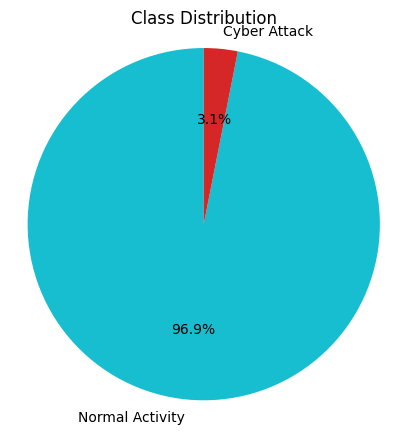

In [35]:
dataset_2, labels_2 = preprocessing(tues_dataset, final_features, 'Label')

#### Dataset 3: Thursday Dataset 1

In [36]:
print("Shape of dataset_3 (Thursday dataset 1):")
thurs_dataset_1.shape

Shape of dataset_3 (Thursday dataset 1):


(458968, 85)

In [37]:
print("Missing values in dataset_3:")
thurs_dataset_1.isnull().sum()

Missing values in dataset_3:


Flow ID              288602
 Source IP           288602
 Source Port         288602
 Destination IP      288602
 Destination Port    288602
                      ...  
Idle Mean            288602
 Idle Std            288602
 Idle Max            288602
 Idle Min            288602
 Label               288602
Length: 85, dtype: int64

There are 288602 rows with mostly null values. Drop these rows. 

In [38]:
# drop all null values
thurs_dataset_1 = thurs_dataset_1 .dropna(how='all')
print(f"The ratio of positive examples is {sum(thurs_dataset_1[' Label'] != 'BENIGN')/len(thurs_dataset_1)}")

The ratio of positive examples is 0.01279598041862813


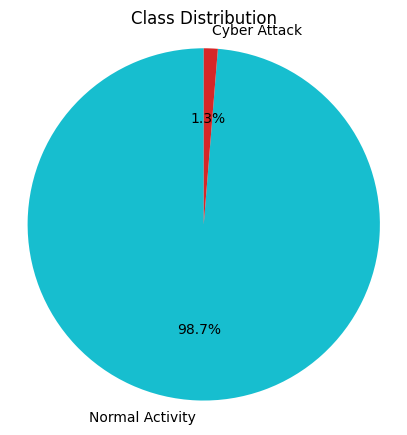

In [39]:
dataset_3, labels_3 = preprocessing(thurs_dataset_1, final_features, 'Label')

#### Dataset 4: Thursday Dataset 2

In [40]:
print("Shape of dataset_4 (Thursday dataset 2):")
thurs_dataset_2.shape

Shape of dataset_4 (Thursday dataset 2):


(288602, 85)

In [41]:
print(f"The ratio of positive examples is {sum(thurs_dataset_2[' Label'] != 'BENIGN')/len(thurs_dataset_2)}")

The ratio of positive examples is 0.00012473926029618645


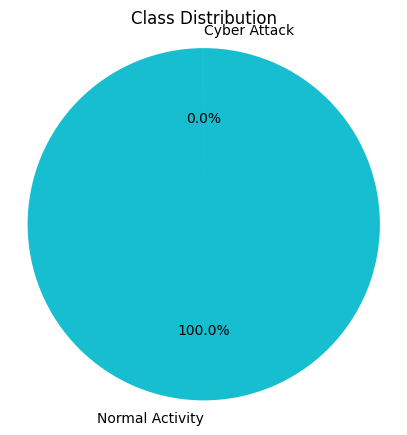

In [42]:
dataset_4, labels_4 = preprocessing(thurs_dataset_2, final_features, 'Label')

#### Dataset 5: Friday Dataset 1

In [43]:
print("Shape of dataset_5 (Friday dataset 1):")
fri_dataset_1.shape

Shape of dataset_5 (Friday dataset 1):


(191033, 85)

In [44]:
print(f"The ratio of positive examples is {sum(fri_dataset_1[' Label'] != 'BENIGN')/len(fri_dataset_1)}")

The ratio of positive examples is 0.010291415619290908


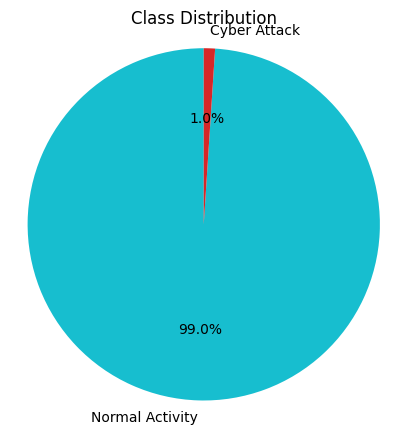

In [45]:
dataset_5, labels_5 = preprocessing(fri_dataset_1, final_features, 'Label')

#### Dataset 6: Friday Dataset 2

In [46]:
print("Shape of dataset_6 (Friday dataset 2):")
fri_dataset_2.shape

Shape of dataset_6 (Friday dataset 2):


(286467, 85)

In [47]:
print(f"The ratio of positive examples is {sum(fri_dataset_2[' Label'] != 'BENIGN')/len(fri_dataset_2)}")

The ratio of positive examples is 0.5547933967961406


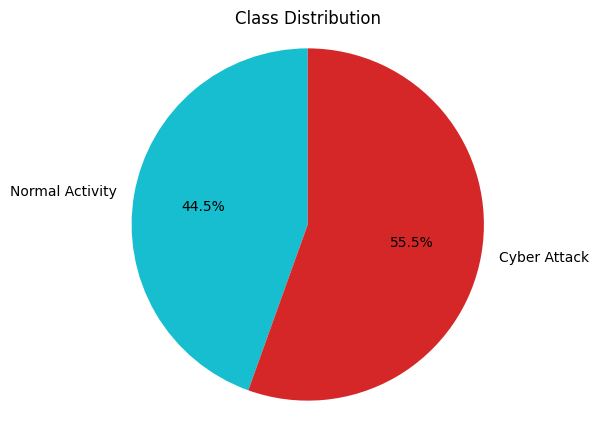

In [48]:
dataset_6, labels_6 = preprocessing(fri_dataset_2, final_features, 'Label')

#### Dataset 7: Friday Dataset 3

In [49]:
print("Shape of dataset_7 (Friday dataset 3):")
fri_dataset_3.shape

Shape of dataset_7 (Friday dataset 3):


(225745, 85)

In [50]:
print(f"The ratio of positive examples is {sum(fri_dataset_3[' Label'] != 'BENIGN')/len(fri_dataset_3)}")

The ratio of positive examples is 0.5671310549513832


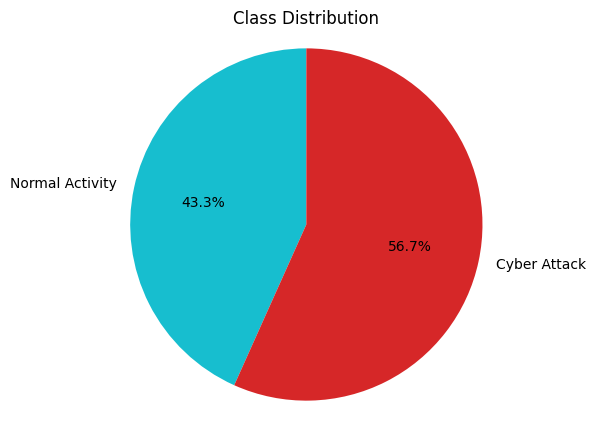

In [51]:
dataset_7, labels_7 = preprocessing(fri_dataset_3, final_features, 'Label')

#### Dataset 8: Monday Dataset

In [52]:
print("Shape of dataset_8 (Monday dataset 1):")
mon_dataset.shape

Shape of dataset_8 (Monday dataset 1):


(529918, 85)

In [53]:
print(f"The ratio of positive examples is {sum(mon_dataset[' Label'] != 'BENIGN')/len(mon_dataset)}")

The ratio of positive examples is 0.0


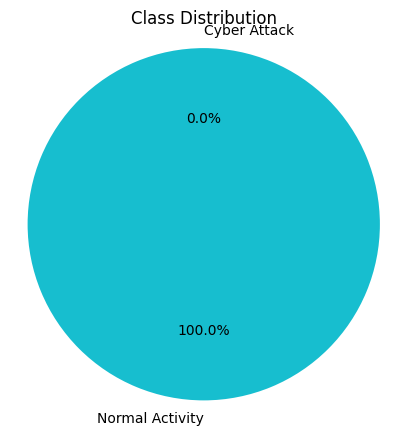

In [54]:
dataset_8, labels_8 = preprocessing(mon_dataset, final_features, 'Label')

A random forest model will be applied to datasets 2-7. Dataset 8 has only one label, and Principal Component Analysis will be applied to this dataset.

### Dataset 2 -Tuesday Dataset

In [55]:
stratified_k_fold(dataset_2, labels_2, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 99.971 ±0.0031, Train F1 Score: 99.540 ±0.0420 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.970 ±0.0094, Test F1 Score: 99.503 ±0.1463 with 10 iterations


### Dataset 3 -Thursday Dataset 1

In [56]:
stratified_k_fold(dataset_3, labels_3, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 99.448 ±0.0101, Train F1 Score: 80.005 ±0.3902 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.443 ±0.0556, Test F1 Score: 79.825 ±1.8662 with 10 iterations


### Dataset 4 -Thursday Dataset 2

In [57]:
stratified_k_fold(dataset_4, labels_4, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 100.000 ±0.0000, Train F1 Score: 86.975 ±2.8380 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.995 ±0.0050, Test F1 Score: 67.958 ±24.5126 with 10 iterations


### Dataset 5 -Friday Dataset 1

In [58]:
stratified_k_fold(dataset_5, labels_5, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 99.630 ±0.0046, Train F1 Score: 78.152 ±0.2789 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.631 ±0.0343, Test F1 Score: 78.101 ±2.5111 with 10 iterations


### Dataset 6 -Friday Dataset 2

In [59]:
stratified_k_fold(dataset_6, labels_6, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 99.949 ±0.0050, Train F1 Score: 99.953 ±0.0065 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.947 ±0.0149, Test F1 Score: 99.953 ±0.0139 with 10 iterations


### Dataset 7 -Friday Dataset 3

In [60]:
stratified_k_fold(dataset_7, labels_7, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 99.442 ±0.3279, Train F1 Score: 99.510 ±0.2878 with 10 iterations
Stratified 10-fold CV Test Accuracy: 99.437 ±0.3334, Test F1 Score: 99.507 ±0.2919 with 10 iterations


The evaluations with lower F1 scores correspond to the three datasets with around 1% or fewer positive attack examples. The limited attack examples in the dataset made these problems more challenging for the machine learning models. The first model only had about 3% of positive examples in the dataset and still reached an F1 score of around 96%. The models that trained on more evenly distributed class examples reached an F1 score higher than 98%. 

### Dataset 8 -Monday Dataset (Unsupervised Learning)

In [61]:
# apply PCA to the dataset
dataset_8 = StandardScaler().fit_transform(dataset_8)

pca = PCA()
data_reduced = pca.fit_transform(dataset_8)

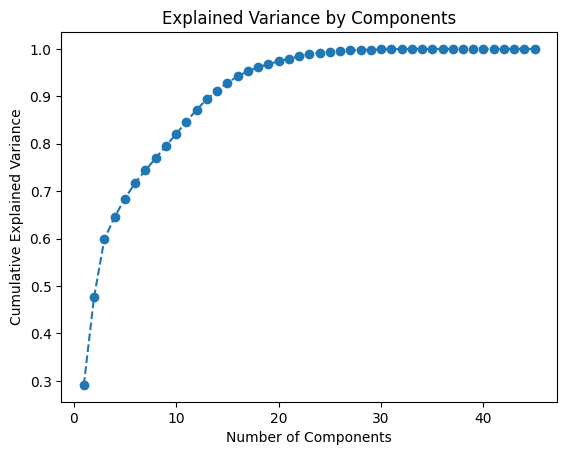

In [62]:
# plot the Scree Plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Based on the Scree plot above, the first 22 principal components account for about 95% of the variance in the dataset.

In [63]:
# Plot two principal components to observe outliers
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(dataset_8)
principal_df = pd.DataFrame(data = data_reduced, columns = ['Principal Component 1', 'Principal Component 2'])

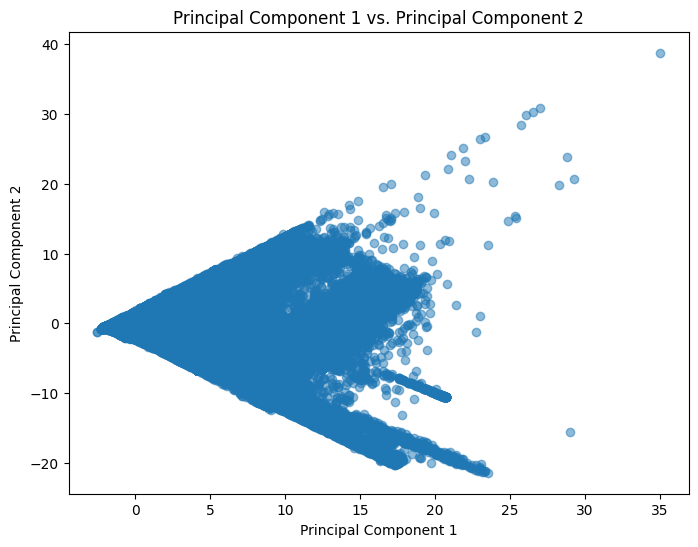

In [64]:
plt.figure(figsize=(8,6))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component 1 vs. Principal Component 2')
plt.show()

The plot of the first two principal components shows most of the data points grouped together in one cluster. The values on the right side of the graph indicate possible outliers.

Developing machine learning models for domains where the researcher is not a subject matter expert presents both challenges and opportunities. As shown in the above analysis, feature selection can be difficult without domain knowledge. The problem of cybersecurity intrusion detection could have benefitted from consulting a subject matter expert about the significance of the removed features. However, feature exploration presents opportunities for the machine learning practitioner to learn more about the problem domain. Further feature exploration for each dataset could have provided more insight into the characteristics of each attack. Model evaluation can also present challenges when the practitioner is not a subject matter expert. Domain experts can often detect when a model makes similar errors and help correct these errors. Furthermore, a machine learning practitioner is more likely to misinterpret model results without consulting a subject matter expert.